### Gathers data from all videos in 'training videos' and displays the data on screen in real time, converts to angles using functions.py, saves the videos to 'training data'. Also visualizes landmark x,y,z coordinates over time and joints over time

In [3]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import functions
#import importlib
#importlib.reload(functions)
import os
from collections import deque

from pathlib import Path
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


In [4]:
window_length = 10
allAngles = []
allPoints = []

#Set up different Joints. The value at index 1 is the middle of the joint
JOINTS_TO_TRACK = {
    "left_elbow": [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST],
    "right_elbow": [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST],
    "left_knee": [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE],
    "right_knee": [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE],
    "right_hip": [mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_SHOULDER],
    "left_hip": [mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_SHOULDER],
    "left_shoulder": [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW],
    "right_shoulder": [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW],
}

landmark_indeces_to_labels = {
    0: "nose",
    1: "left eye inner",
    2: "left eye",
    3: "left eye outer",
    4: "right eye inner",
    5: "right eye",
    6: "right eye outer",
    7: "left ear",
    8: "right ear",
    9: "mouth left",
    10: "mouth right",
    11: "left shoulder",
    12: "right shoulder",
    13: "left elbow",
    14: "right elbow",
    15: "left wrist",
    16: "right wrist",
    17: "left pinky",
    18: "right pinky",
    19: "left index",
    20: "right index",
    21: "left thumb",
    22: "right thumb",
    23: "left hip",
    24: "right hip",
    25: "left knee",
    26: "right knee",
    27: "left ankle",
    28: "right ankle",
    29: "left heel",
    30: "right heel",
    31: "left foot index",
    32: "right foot index"
}

#initializes a map to store the x,y,z coordinate of each body part at each frame
landmark_positions = {}
for position in mp_pose.PoseLandmark:
    landmark_positions[position.value] = [[],[],[]]

#Stores the angles calculated at each frame in a different map
angle_history = {joint: [] for joint in JOINTS_TO_TRACK}

# Get current script, and find the training videos script relative to it
script_dir = os.path.dirname(os.path.abspath("main.ipynb"))
videos_dir = os.path.abspath(os.path.join(script_dir, '..', 'training videos'))

# Normalize path just for fun
videos_dir = os.path.normpath(videos_dir)

In [7]:
cap = cv2.VideoCapture()


for filename in os.listdir(videos_dir):
    if filename.endswith(('.mp4', '.avi', '.MOV', 'mkv')):  # filter video files

        video_path = os.path.join(videos_dir, filename)
        cap = cv2.VideoCapture(video_path)

        #UNCOMMENT TO RECORD MEDIAPIPE FOOTAGE
        '''fps = cap.get(cv2.CAP_PROP_FPS)
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(f'{filename} annotated_output.mp4', fourcc, fps, (width, height))'''

        if not cap.isOpened():
            continue

        with mp_pose.Pose(min_detection_confidence=0.85, min_tracking_confidence=0.85) as pose:

            #Store Angle History
            angle_windows = {}

            for joint_name in JOINTS_TO_TRACK.keys():
                # INIT DEQUES TO TAKE THE AVERAGE OF DATA IN A "SLIDING WINDOW"
                # THIS HELPS TO SMOOTH THE DATA. Adjust Window Length to set smoothness
                # of data
                angle_windows[joint_name] = deque([], maxlen=window_length)

            while cap.isOpened():
                ret, frame = cap.read()

                #Detect if video loop is over and update data
                if not ret:
                    points = {f"landmark_{k}": np.array(v) for k, v in landmark_positions.items()}

                    # points={}
                    # for k, v in landmark_positions.items():
                    #     points[f'landmark_{k}'] = np.array(v[2])
                    angles = {k: np.array(v) for k, v in angle_history.items()}

                    # Isolates file tag, number, and good/bad
                    # ex. deadlift 1 good
                    file_tag = " ".join(filename.split(".")[:1])
                    if filename.startswith("squat"):
                        functions.save_lift_data(file_tag, points, angles, filename_tag=filename)
                    elif filename.startswith("bench"):
                        functions.save_lift_data(file_tag, points, angles, filename_tag=filename)
                    elif filename.startswith("deadlift"):
                        functions.save_lift_data(file_tag, points, angles, filename_tag=filename)
                    break

                #Recolor the frame to RGB
                image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                results = pose.process(image)

                #Recolor the frame back to BGR
                image.flags.writeable = True
                image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)



                try:
                    #EXTRACT LANDMARKS AND APPEND X,Y,Z COORDS TO LANDMARK_POSITIONS
                    landmarks = results.pose_landmarks.landmark
                    for position in mp_pose.PoseLandmark:
                        landmark = landmarks[position.value]
                        landmark_positions[position.value][0].append(round(landmark.x,2))
                        landmark_positions[position.value][1].append(round(landmark.y,2))
                        landmark_positions[position.value][2].append(round(landmark.z,2))


                    # GO THRU EACH JOINT GIVEN IN JOINTS_TO_TRACK
                    # landmark_indeces represent the landmarks we passed to JOINTS_TO_TRACK

                    # for example, if joint_name = left elbow, then the landmark indeces are
                    # the left wrist, elbow, and shoulder, and you can access the x,y,z coordinates
                    # of each of these by index
                    for joint_name, landmark_indices in JOINTS_TO_TRACK.items():

                        try: #EXECUTE IF JOINT HAS ACTIVE DATA

                            a = landmarks[landmark_indices[0].value]
                            b = landmarks[landmark_indices[1].value]
                            c = landmarks[landmark_indices[2].value]

                            # Use only x, y for 2D analysis
                            angle = functions.calculate_angle(
                                [a.x, a.y, a.z],
                                [b.x, b.y, b.z],
                                [c.x, c.y, c.z]
                            )

                        # ADD CURRENT ANGLE AT FRAME TO ANGLE_WINDOWS. IF ANGLE_WINDOWS IS AS LONG AS THE DEQUE EARLIER,
                        # TAKE THE MEAN OF THE DEQUE. DEQUE IS UPDATED AT EACH FRAME, WITH THE FIRST VALUE IN THE DEQUE
                        # BEING REMOVED AS THE LAST IS ADDED (FIFO DATA STRUCTURE)
                            angle_windows[joint_name].append(angle)
                            if len(angle_windows[joint_name]) == window_length:
                                rolling_avg = np.mean(angle_windows[joint_name])
                                angle_history[joint_name].append(int(rolling_avg))

                            #ADD COORDINATES TO VIDEO
                            x = a.x * cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                            y = a.y * cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
                            cv2.putText(image, f"{str(round(x ,2))}  {str(round(y,2))} {str(round(a.z,2))}",
                                np.multiply([a.x, a.y-.02], [cap.get(cv2.CAP_PROP_FRAME_WIDTH),cap.get(cv2.CAP_PROP_FRAME_HEIGHT)]).astype(int), cv2.FONT_HERSHEY_SIMPLEX,
                                0.5, (100,200,200), 2, cv2.LINE_AA)

                        #IF LANDMARK IS NOT FOqUND IN FOOTAGE, SET ANGLE TO NOT A NUMBER
                        except Exception:
                            angle = np.nan

                        #IF WE HAVE AN ACTIVE ANGLE, DISPLAY THE ANGLE ON SCREEN
                        '''if not np.isnan(angle):
                            b_coords = np.multiply([b.x, b.y], [image.shape[1], image.shape[0]]).astype(int)
                            cv2.putText(
                                image,
                                f"{joint_name}: {int(angle)}",
                                tuple(b_coords),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.5,
                                (255,255,255),
                                2,
                                cv2.LINE_AA
                            )'''
                #IF WE CANNOT EXTRACT LANDMARKS, JUST PASS
                except:
                    pass

                #DRAW LANDMARKS AND CONNECTIONS IN VIDEO
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                          mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                          )
                cv2.imshow('Mediapipe Feed',image)

                # UNCOMMENT TO RECORD MEDIAPIPE FOOTAGE
                #out.write(image)


                #IF USER PRESSES Q, EXIT
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    print("User requested exit.")
                    break

            #UNCOMMENT TO RECORD MEDIAPIPE FOOTAGE
            #out.release()
            cv2.destroyAllWindows()

    cap.release()
    cv2.destroyAllWindows()

User requested exit.
User requested exit.
User requested exit.
User requested exit.
User requested exit.
User requested exit.
User requested exit.
User requested exit.
User requested exit.


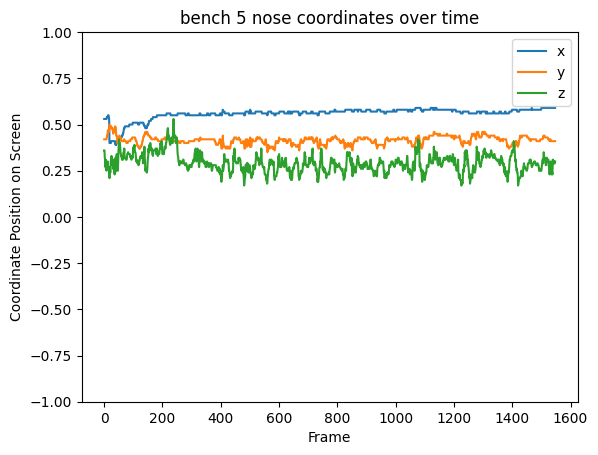

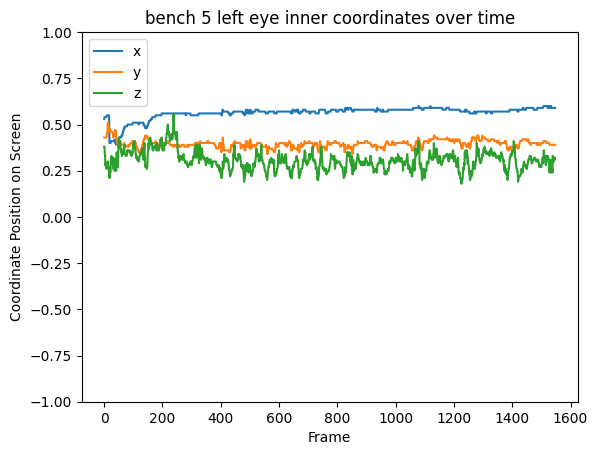

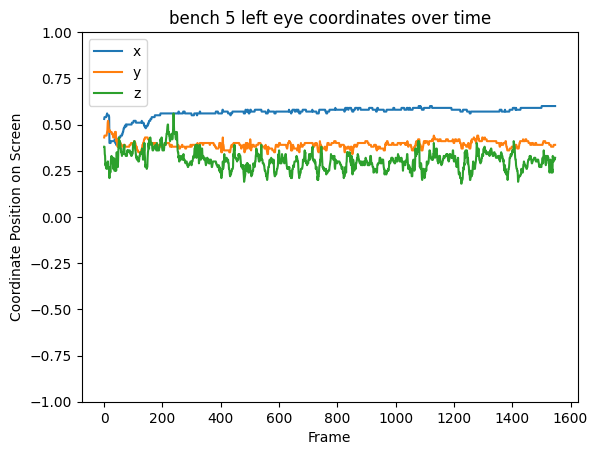

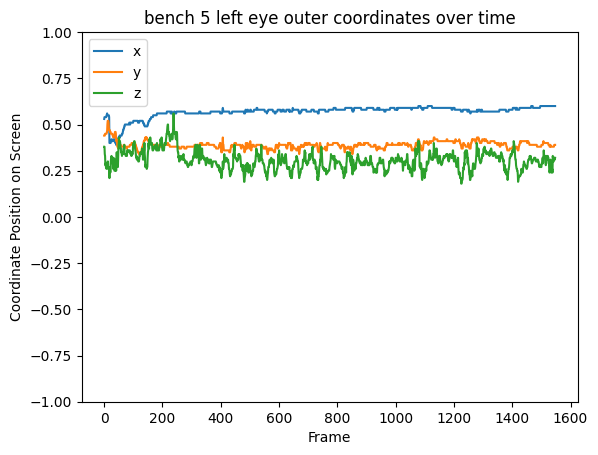

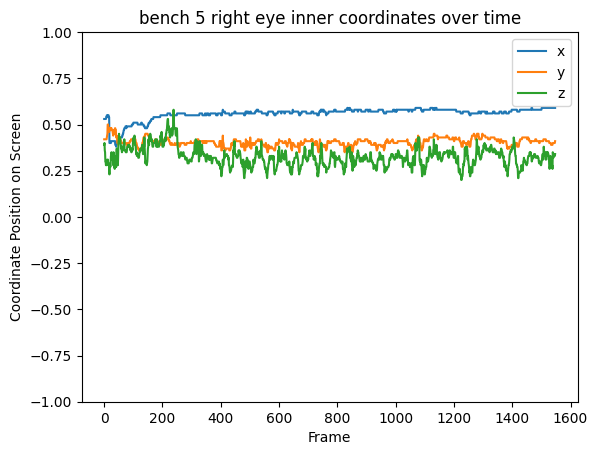

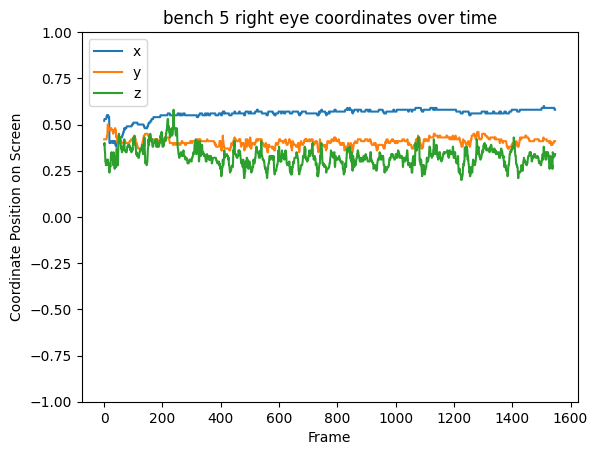

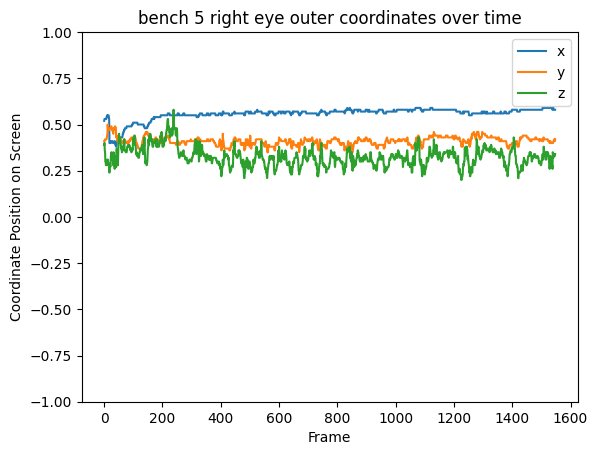

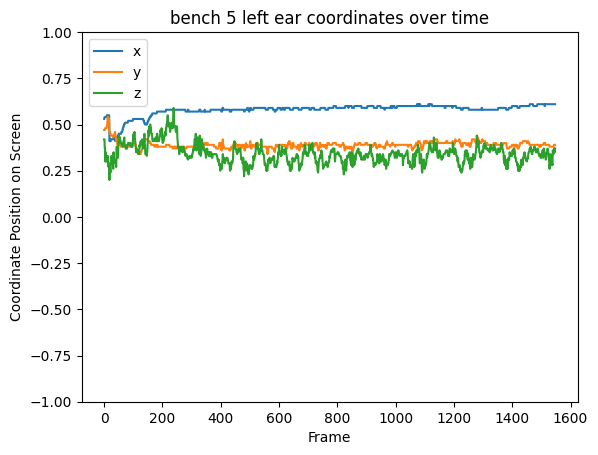

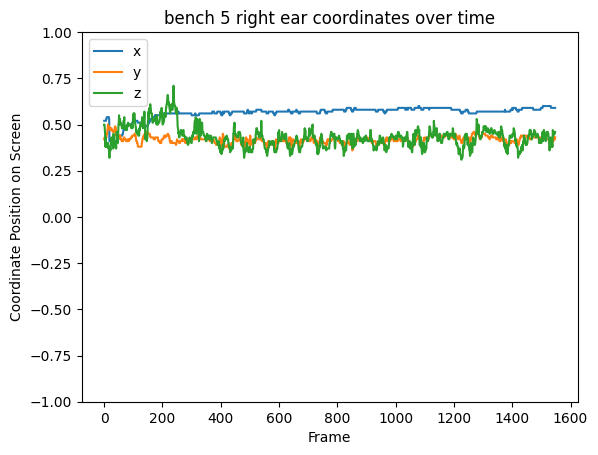

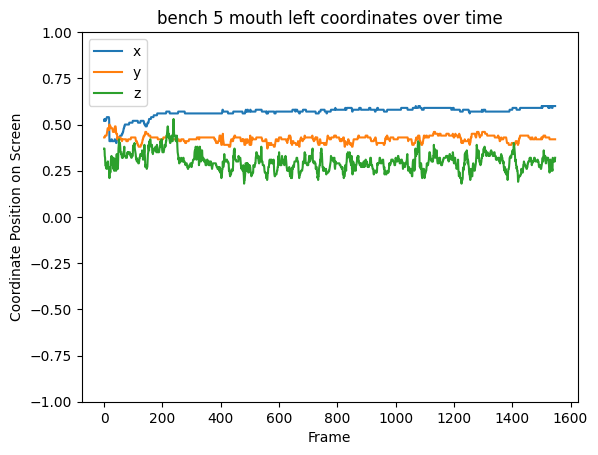

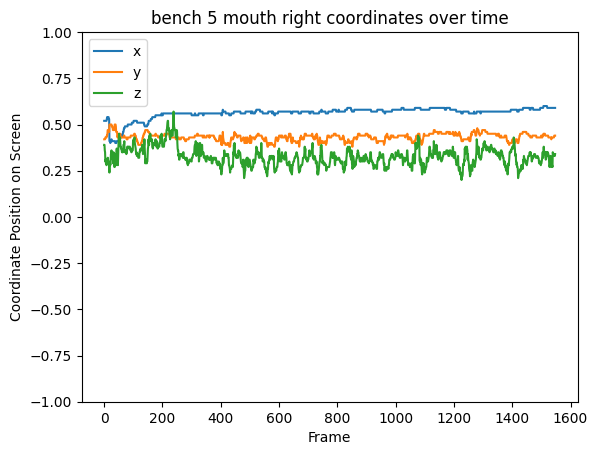

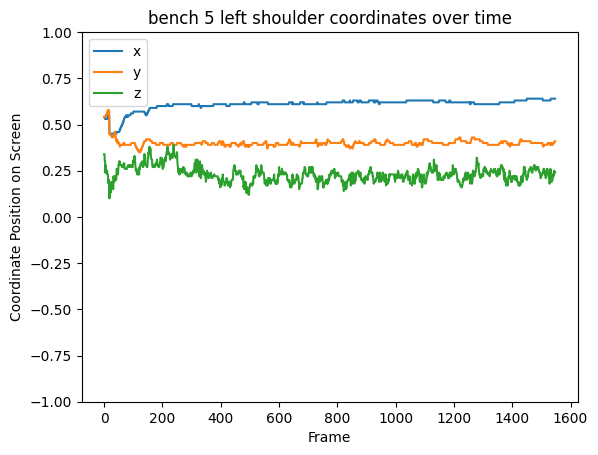

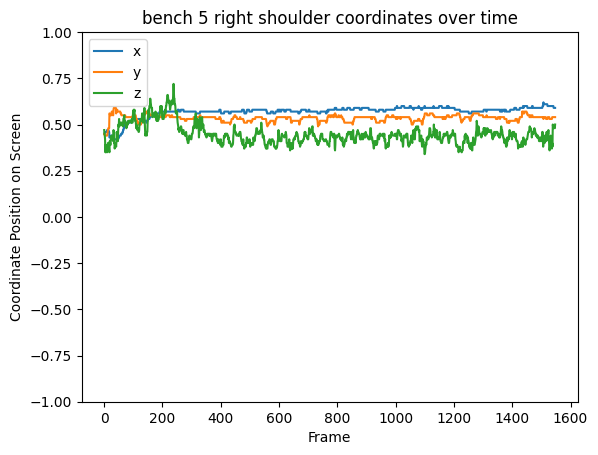

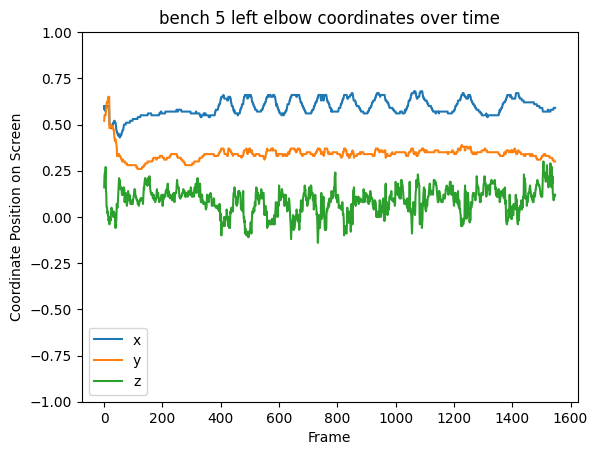

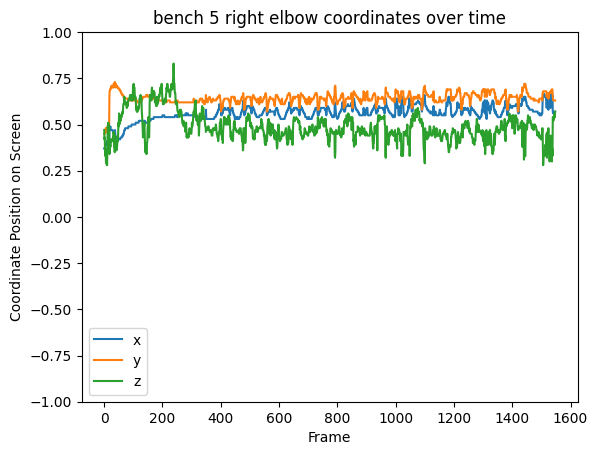

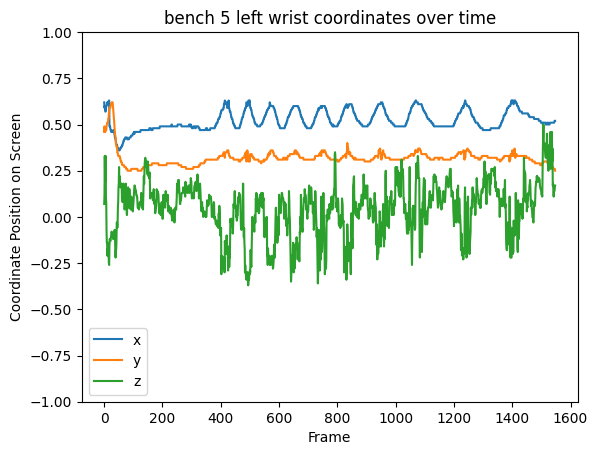

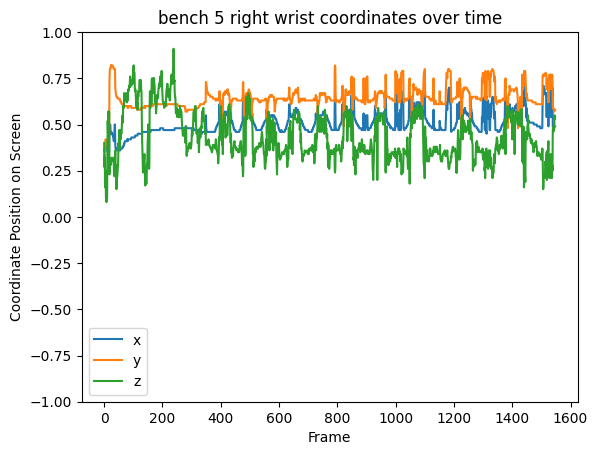

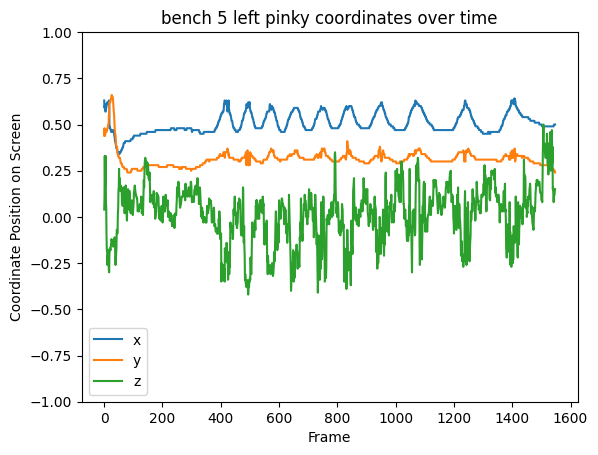

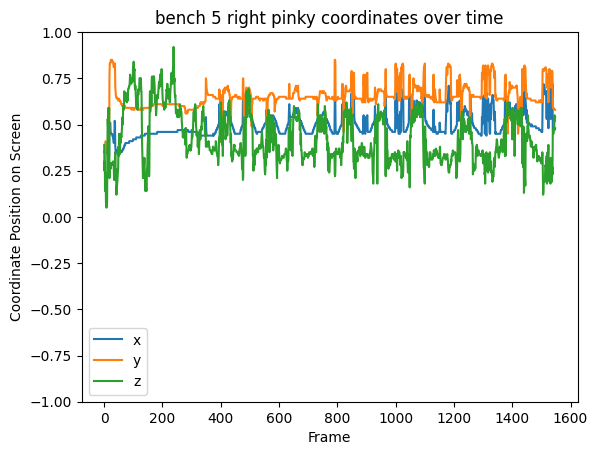

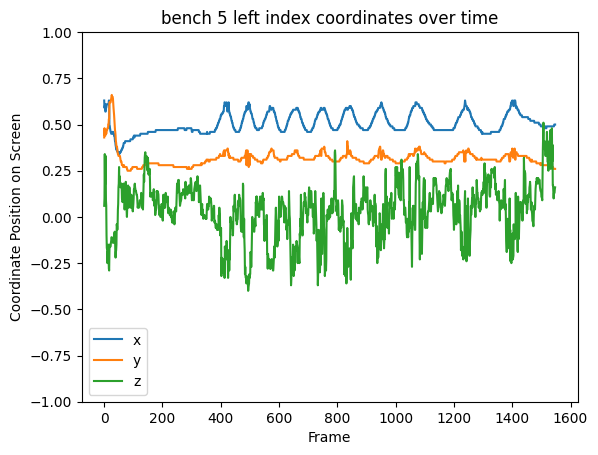

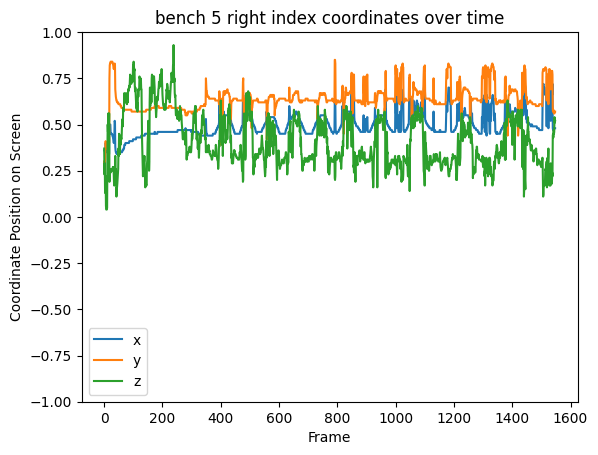

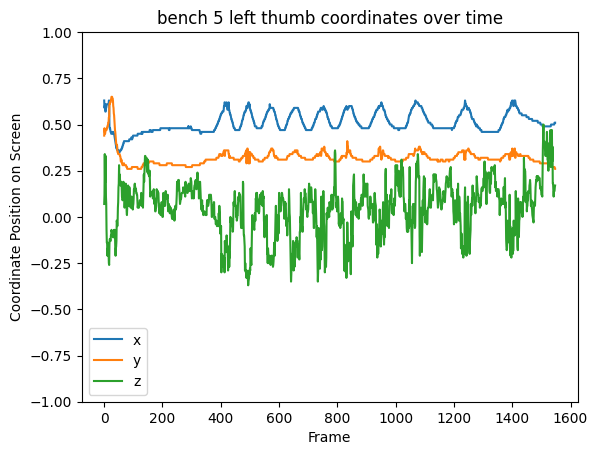

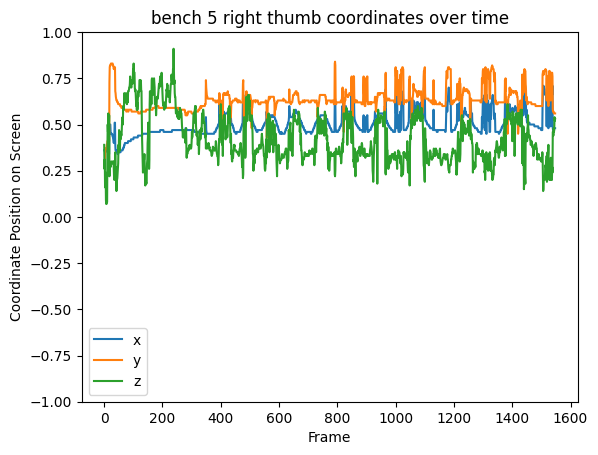

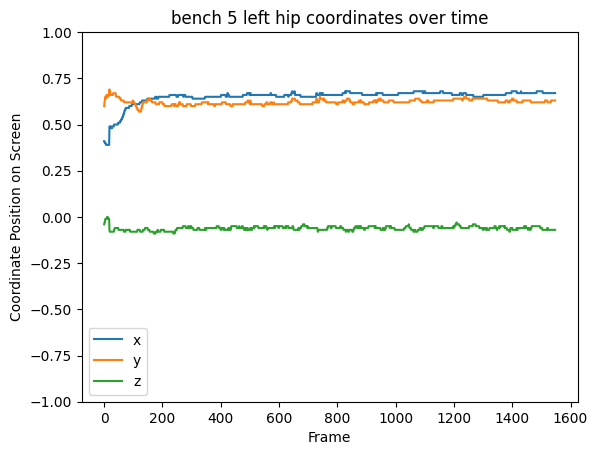

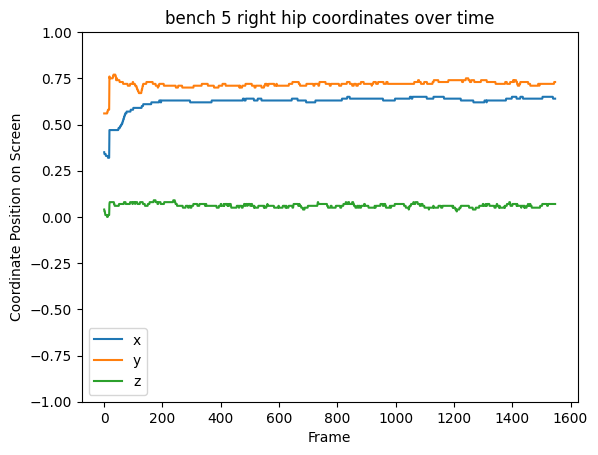

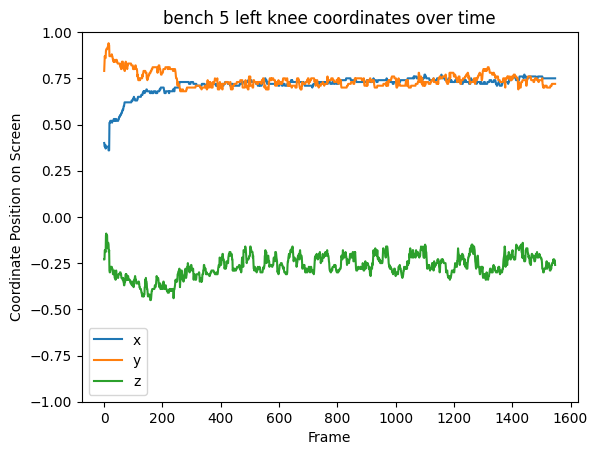

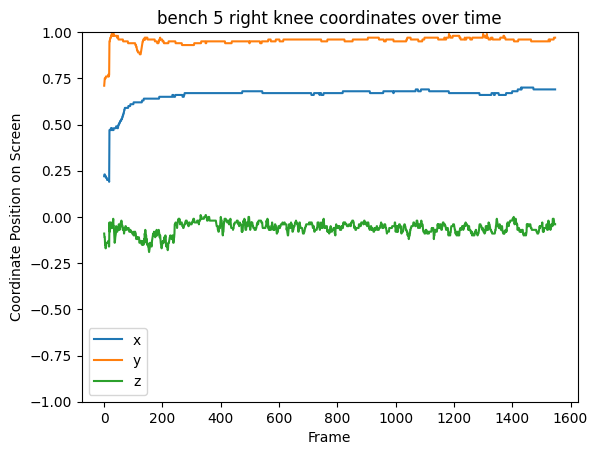

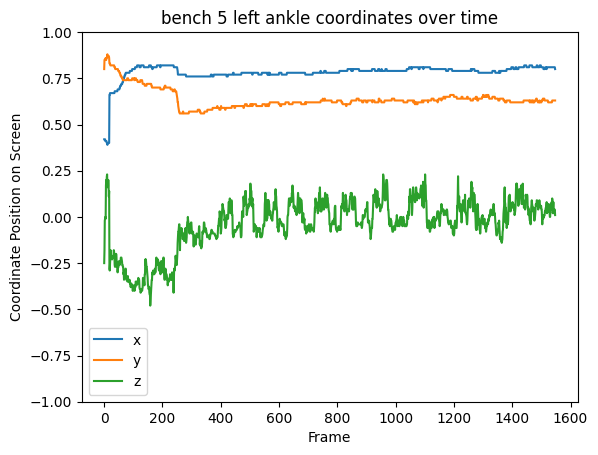

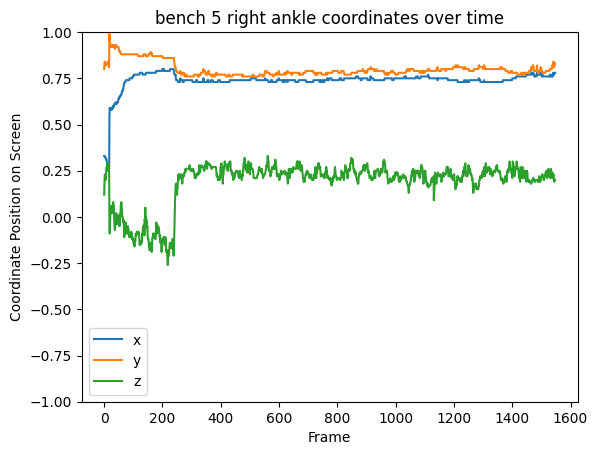

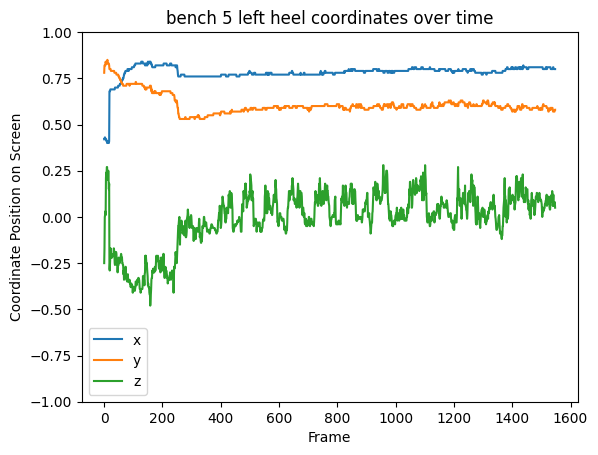

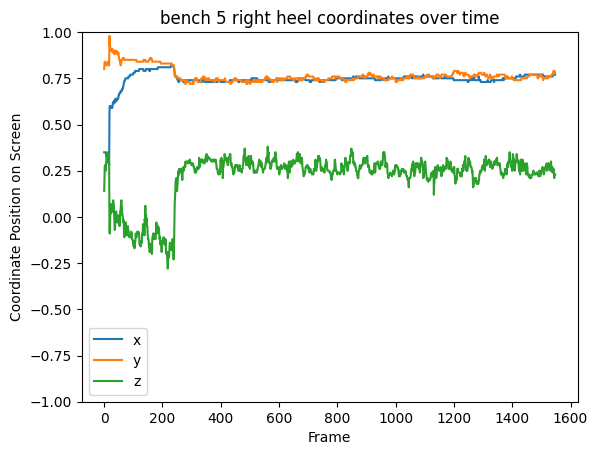

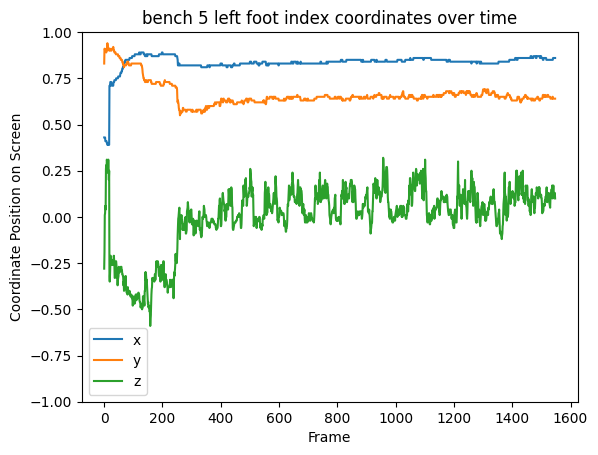

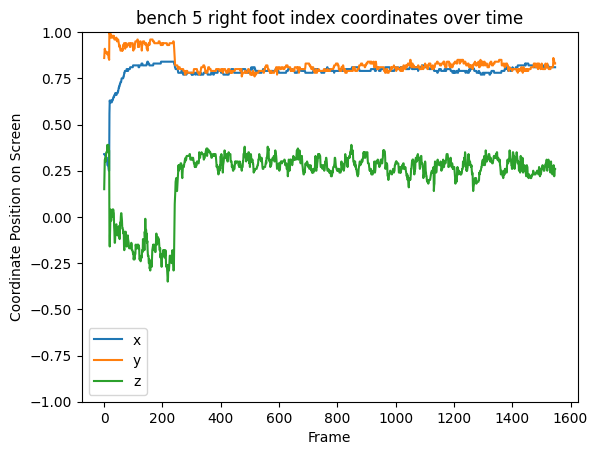

bench 5 good.MOV_left_elbow: shape = (1530,)


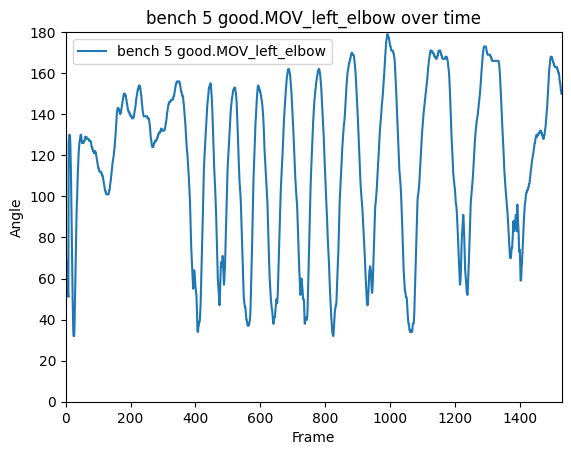

bench 5 good.MOV_right_elbow: shape = (1530,)


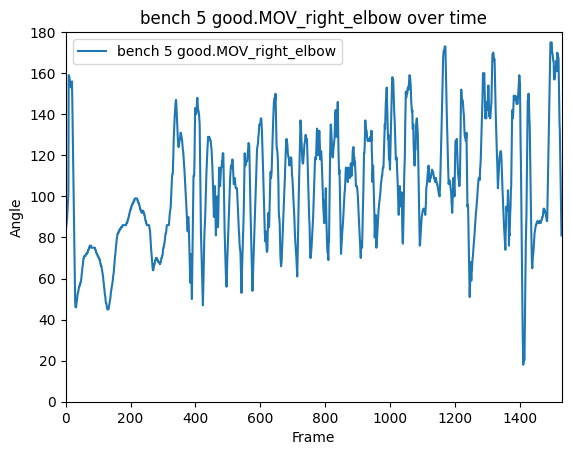

bench 5 good.MOV_left_knee: shape = (1530,)


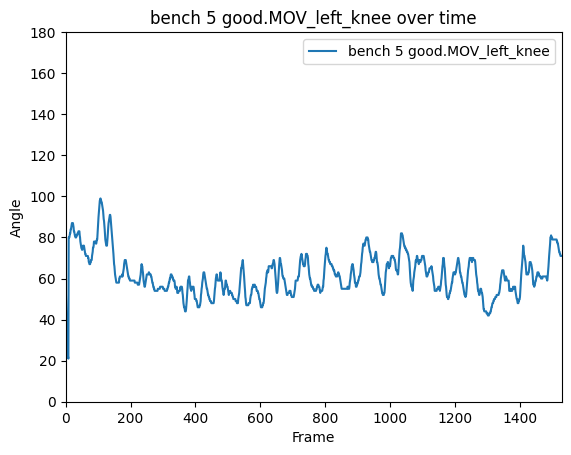

bench 5 good.MOV_right_knee: shape = (1530,)


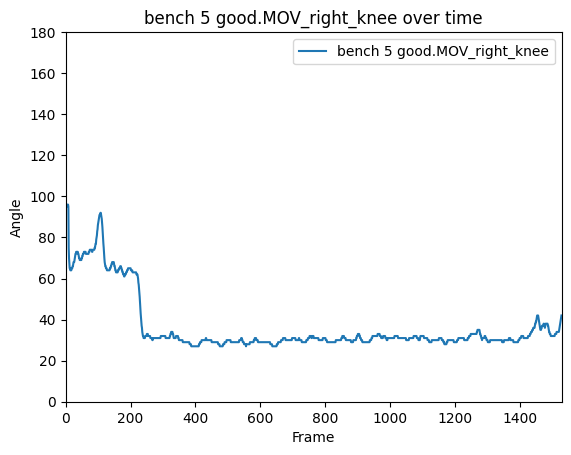

bench 5 good.MOV_right_hip: shape = (1530,)


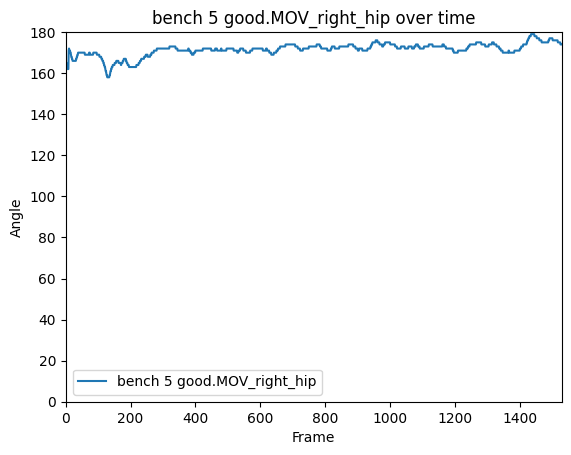

bench 5 good.MOV_left_hip: shape = (1530,)


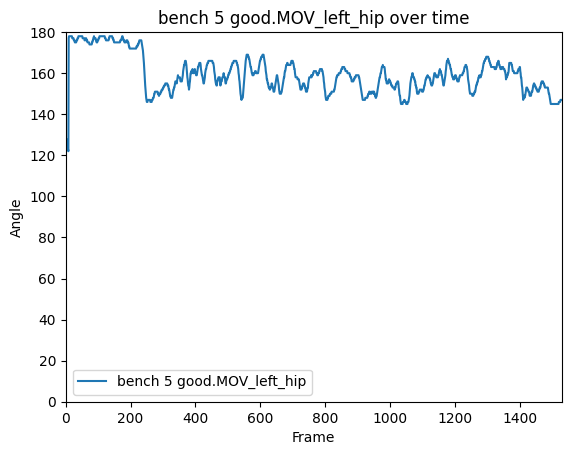

bench 5 good.MOV_left_shoulder: shape = (1530,)


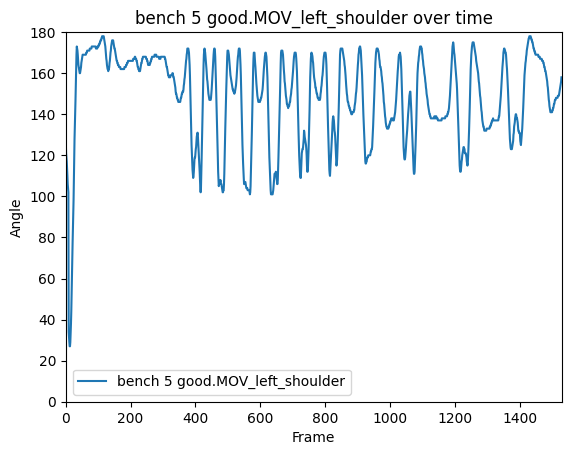

bench 5 good.MOV_right_shoulder: shape = (1530,)


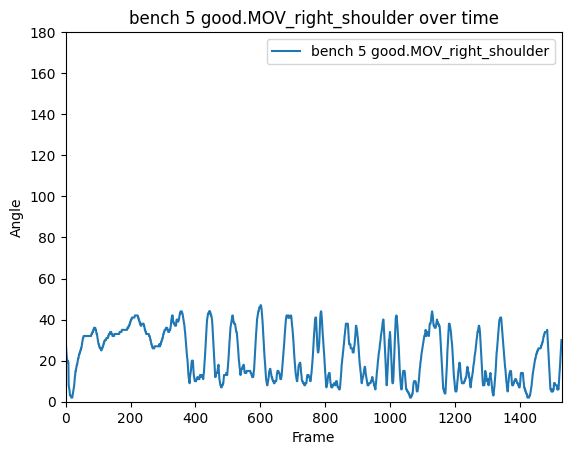

In [6]:
# NPZ VIEWING
# Adjust data file path to view data for single lift of your choice
import numpy as np
import matplotlib.pyplot as plt

#CHANGE FILES TO VIEW DIFFERENT LIFTS
data_dir = os.path.join(script_dir, '..', 'training data')
data = np.load(f"{data_dir}\\bench files\\bench 5 good lift data.npz")


#print(data)
# for key in data:
#     joint_data = data[key]
#     print(f"{key}: shape = {joint_data.shape}")
#     plt.plot(joint_data, label=key)
#     plt.title(f"{key} over time")
#     plt.xlabel("Frame")
#     plt.xlim(0,joint_data.shape[0])
#     plt.ylim(0,180)
#     plt.ylabel("Angle")
#
#     plt.legend()
#     plt.show()

i = 0

for key in data:
    if "landmark" in key:
        for coordinate in data[key]:
            # ISOLATE THE INDEX WHERE LANDMARK NAME IS FOUND SO WE CNA ISOLATE LANDMARK NAME
            # indexing is getting a little convoluted. Just know that this isolates the
            # landmark index and maps it to the landmark name
            s = key.find("landmark_")
            current_landmark_index = int(key[s+9:])
            current_landmark_name = landmark_indeces_to_labels[current_landmark_index]

            plt.plot(coordinate, label=chr(120+i))
            i += 1
            if i == 3:
                i = 0

        plt.title(f"{key[:s - 9]}{current_landmark_name} coordinates over time")
        plt.xlabel("Frame")
        plt.ylabel('Coordinate Position on Screen')
        plt.ylim(-1,1)
        plt.legend()
        plt.show()
    else:
        joint_data = data[key]
        print(f"{key}: shape = {joint_data.shape}")
        plt.plot(joint_data, label=key)
        plt.title(f"{key} over time")
        plt.xlabel("Frame")
        plt.xlim(0,joint_data.shape[0])
        plt.ylim(0,180)
        plt.ylabel("Angle")

        plt.legend()
        plt.show()
